# Welcome to LightRidge — An Open-Source Hardware Project for Optical AI

The following tutorial is a LightRidge tutorial of building a basic diffractive optical neural networks (DONNs)

### NOTE: <font color='red'>This colab code is tested with free colab runtime for simple Artifact Evaluation (ASPLOS'24) </font>. For better runtime, please use your own GPU server.


In [ ]:
!pip install lightridge

## Step 1: LightRidge installation



<h1>LightRidge Design Flow</h1>


<p><img alt="LightRidge Design Flow" height="245px" src="https://lightridge.github.io/lightridge/_images/lightridge_flow.png" align="left" hspace="10px" vspace="0px"></p>

More can be found at https://lightridge.github.io/lightridge/index.html#




## Step 2: Check LightRidge installation



In [ ]:
import lightridge
import lightridge.layers as layers
import lightridge.utils as utils
import lightridge.data as dataset
from   lightridge.get_h import _field_Fresnel

/home/cunxi/.conda/envs/rl/lib/python3.7/site-packages/lightridge-0.2.0-py3.7.egg/lightridge/get_h.py:27: UserWarning: 
**************************** WARNING ***********************
LightPipes: Cannot import pyFFTW, falling back to numpy.fft.
(Try to) install pyFFTW on your computer for faster performance.
Enter at a terminal prompt: python -m pip install pyfftw.
Or reinstall LightPipes with the option pyfftw
Enter: python -m pip install lightpipes[pyfftw]

You can suppress warnings by using the -Wignore option:
Enter: python _Wignore *****.py
*************************************************************


### GPU Details

The GPU details can be accessed by `!nvidia-smi`.

In [ ]:
!nvidia-smi

Mon Oct  2 18:45:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:18:00.0 Off |                  N/A |
| 32%   38C    P0    67W / 250W |      3MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 32%   

## Step 3: Load additional packages and configure your training device

In [ ]:
import os
import csv
from time import time
import random
import pathlib
import argparse
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
device='cuda:0'

In [ ]:
from platform import python_version
print("Python version", python_version())
print("Pytorch - version", torch.__version__)
print("Pytorch - cuDNN version :", torch.backends.cudnn.version())

Python version 3.7.9
Pytorch - version 1.12.0+cu102
Pytorch - cuDNN version : 7605


## Step 4: Constructing DONNs
The DONN model is constructed here. With defined diffractive layers and parameters, the model class works as a sequential container that stacks arbitrary numbers of customized diffractive layers in the order of light propagation in the DONN system and a detector plane. As a result, we construct a complete DONN system just like constructing a conventional neural network.

![DONN Overview](https://lightridge.github.io/lightridge/_images/sci18.jpg)




1. Set the hardware information for the emulation

*   Input laser source information: *wavelength* (532e-9)
*   System size: *sys_size* (200)
*   Pixel size: *pixel_size* (3.6e-5)
*   Padding size for emulations: *pad* (100)

2.   Define the system parameters for model construction

*   Diffractive layers: inlcudes diffraction approximation and phase modulation in *layers.DiffractLayer_Raw/layers.DiffractLayer*:
  - Mathematical approximation for light diffraction: *approx*
  - Diffraction distance: *distance*
  - System depth: *num_layers*
  - Training regularization: *amp_factor*


*   Detector design: defined in *layers.Detector*:
  - Location coordinate for detector regions: *det_loc_x,
det_loc_y*,
  - Size for each sub-detector: *det_size*





3.   Visualization functions
*    Propogation pattern visualization: *prop_view*
*    Trainable parameter, phase modulation visualization: *phase_view*



In [ ]:
class DiffractiveClassifier_Raw(torch.nn.Module):
    def __init__(self, device, det_x_loc, det_y_loc, det_size, wavelength=5.32e-7, pixel_size=0.000036,
                 batch_norm=False, sys_size = 200, pad = 100, distance=0.1, num_layers=2, amp_factor=6, approx="Fresnel3"):
        super(DiffractiveClassifier_Raw, self).__init__()
        self.amp_factor = amp_factor
        self.size = sys_size
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_size = pixel_size
        self.pad = pad
        self.approx=approx
        self.diffractive_layers = torch.nn.ModuleList([layers.DiffractLayer_Raw(wavelength=self.wavelength, pixel_size=self.pixel_size,
                                                                                    size=self.size, pad = self.pad, distance=self.distance,
                                                                                    amplitude_factor = amp_factor, approx=self.approx,
                                                                                    phase_mod=True) for _ in range(num_layers)])
        self.last_diffraction = layers.DiffractLayer_Raw(wavelength=self.wavelength, pixel_size=self.pixel_size,
                                                            size=self.size, pad = self.pad, distance=self.distance,
                                                            approx=self.approx, phase_mod=False)
        self.detector = layers.Detector(x_loc=det_x_loc, y_loc=det_y_loc, det_size=det_size, size=self.size)

    def forward(self, x):
        for index, layer in enumerate(self.diffractive_layers):
            x = layer(x)
        x = self.last_diffraction(x)
        output = self.detector(x)
        return output

    def prop_view(self, x):
        prop_list = []
        prop_list.append(x)
        x = x #* self.amp_factor
        for index, layer in enumerate(self.diffractive_layers):
            x = layer(x)
            prop_list.append(x)
        x = self.last_diffraction(x)
        prop_list.append(x)
        for i in range(x.shape[0]):
            print(i)
            utils.forward_func_visualization(prop_list, self.size, fname="mnist_%s.pdf" % i, idx=i, intensity_plot=False)
        output = self.detector(x)
        return

    def phase_view(self, cmap="hsv"):
        phase_list = []
        for index, layer in enumerate(self.diffractive_layers):
            phase_list.append(layer.phase)
        print(phase_list[0].shape)
        utils.phase_visualization(phase_list,size=self.size, cmap=cmap, fname="prop_view_reflection.pdf")
        return

## Step 5: Training DONNs
The fully differentiable DONN system can use conventional backpropagation engine to optimize.


In [ ]:
def train(model,train_dataloader, val_dataloader, epochs, lr):
    criterion = torch.nn.MSELoss(reduction='sum').to(device)
    print('training starts.')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.5)

    for epoch in range(epochs):
        log = []
        model.train()
        train_len = 0.0
        train_running_counter = 0.0
        train_running_loss = 0.0
        tk0 = tqdm(train_dataloader, ncols=150, total=int(len(train_dataloader)))
        for train_iter, train_data_batch in enumerate(tk0):
            train_images, train_labels = utils.data_to_cplex(train_data_batch, device='cuda:0')
            train_outputs = model(train_images)
            train_loss_ = criterion(train_outputs, train_labels)
            train_counter_ = torch.eq(torch.argmax(train_labels, dim=1), torch.argmax(train_outputs, dim=1)).float().sum()

            optimizer.zero_grad()
            train_loss_.backward(retain_graph=True)
            optimizer.step()
            train_len += len(train_labels)
            train_running_loss += train_loss_.item()
            train_running_counter += train_counter_

            train_loss = train_running_loss / train_len
            train_accuracy = train_running_counter / train_len

            tk0.set_description_str('Epoch {}/{} : Training'.format(epoch, epochs))
            tk0.set_postfix({'Train_Loss': '{:.2f}'.format(train_loss), 'Train_Accuracy': '{:.5f}'.format(train_accuracy)})
        scheduler.step()
        val_loss, val_accuracy = eval(model, val_dataloader, epoch)


    return train_loss, train_accuracy, val_loss, val_accuracy, log

In [ ]:
def eval(model, val_dataloader, epoch):
    criterion = torch.nn.MSELoss(reduction='sum').to(device)
    with torch.no_grad():
        model.eval()
        val_len = 0.0
        val_running_counter = 0.0
        val_running_loss = 0.0

        tk1 = tqdm(val_dataloader, ncols=100, total=int(len(val_dataloader)))
        for val_iter, val_data_batch in enumerate(tk1):
            val_images, val_labels = utils.data_to_cplex(val_data_batch,device='cuda:0')
            val_outputs = model(val_images)

            val_loss_ = criterion(val_outputs, val_labels)
            val_counter_ = torch.eq(torch.argmax(val_labels, dim=1), torch.argmax(val_outputs, dim=1)).float().sum()

            val_len += len(val_labels)
            val_running_loss += val_loss_.item()
            val_running_counter += val_counter_

            val_loss = val_running_loss / val_len
            val_accuracy = val_running_counter / val_len

            tk1.set_description_str('Validating')
            tk1.set_postfix({'Val_Loss': '{:.5f}'.format(val_loss), 'Val_Accuarcy': '{:.5f}'.format(val_accuracy)})
    return val_loss, val_accuracy

In [ ]:
# Parameters define
batch_size = 500
sys_size = 200
distance = 0.3
pixel_size = 3.6e-5
pad = 100
wavelength = 5.32e-7
approx = 'Fresnel'
amp_factor = 1.5
depth = 5
device = "cuda:0"
epochs = 10
lr = 0.1
det_x_loc = [40, 40, 40, 90, 90, 90, 90, 140, 140, 140]
det_y_loc = [40, 90, 140, 30, 70, 110, 150, 40, 90, 140]
det_size = 20

In [ ]:
# dataset loader
load_dataset = dataset.load_dataset(batch_size = batch_size, system_size = sys_size, datapath = "./data")
train_dataloader, val_dataloader = load_dataset.MNIST()
#train_dataloader, val_dataloader = load_dataset.FMNIST()

# model construction
model = DiffractiveClassifier_Raw(num_layers=depth, batch_norm =False,device=device,
                        #det_y_loc = [105, 125, 145, 95, 115, 135, 155, 105, 125, 145], #det_y_loc = [175,195,215,165,185,205,225,175,195,215],
                        #det_x_loc = [105, 105, 105, 125, 125, 125, 125, 145, 145, 145], #, det_x_loc = [175,175,175,195,195,195,195,215,215,215],
                        #det_size = 10,
                        det_x_loc = det_x_loc,
                        det_y_loc = det_y_loc,
                        det_size = det_size,
                        wavelength=wavelength, pixel_size = pixel_size, sys_size=sys_size, pad = pad,
                        distance=distance,amp_factor=amp_factor, approx=approx)
model.to(device)

# mode training
train(model, train_dataloader, val_dataloader, epochs, lr)

Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation


/home/cunxi/.conda/envs/rl/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
Network is constructed using Fresnel approximation
training starts.


Validating: 100%|███████████| 20/20 [00:03<00:00,  5.99it/s, Val_Loss=0.14873, Val_Accuarcy=0.93260]


(0.15468412818908692,
 tensor(0.9263, device='cuda:0'),
 0.14872540073394774,
 tensor(0.9326, device='cuda:0'),
 [])

**Note: We only showcase 10 epochs in this tutorial example to save the time. To reproduce the full results, you will need 100 epochs as reported in our paper.**

## Step 6: Visualizations


torch.Size([200, 200])


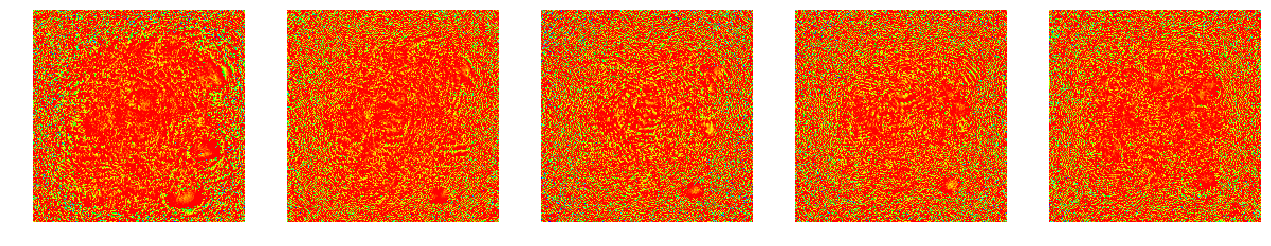

In [ ]:
# Visualization for phase modulation
model.phase_view(cmap="hsv")

0
7 torch.Size([200, 200])
0
7 torch.Size([200, 200])


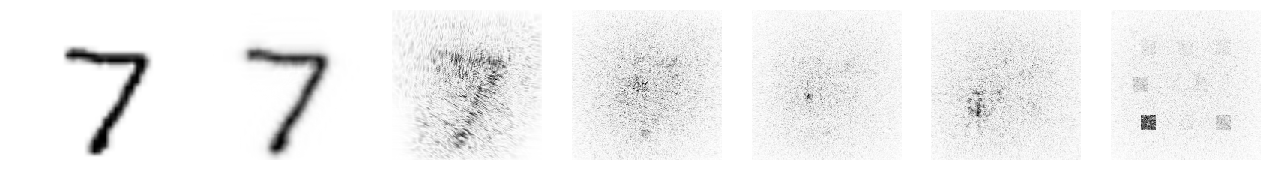

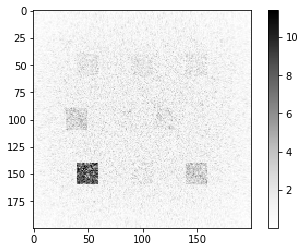

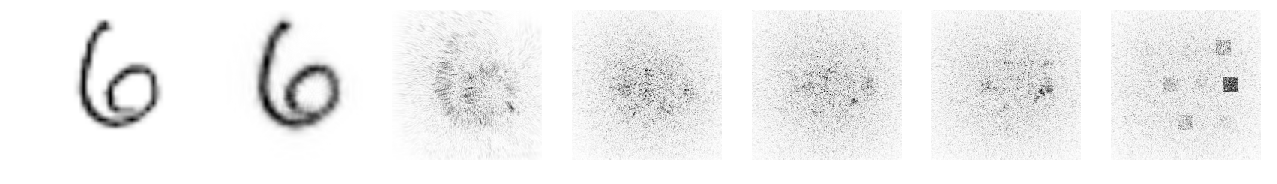

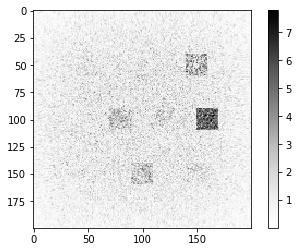

In [ ]:
# Visualization for propagation
transform = transforms.Compose([transforms.Resize((sys_size),interpolation=2),transforms.ToTensor()])
val_dataset = torchvision.datasets.MNIST("./data/", train=False, transform=transform, download=True)

with torch.no_grad():
  model.eval()
  # feel free to add more round of inference test to see the magic of DONNs in Tasks!
  # You just need to replace the index of the val_dataset vector.
  # example round 1
  val_img, val_label =val_dataset[0]
  model.prop_view(val_img.to(device))
  # example round 2
  val_img, val_label =val_dataset[100]
  model.prop_view(val_img.to(device))

## Step7: Change the DONN model with codesign information

The measured quantization vector w.r.t the SLM is stored in folder *device_parameters* including the phase measurements, i.e., phase modulation vs applied voltage stage, in *phase.csv*, and the intensity measurements, i.e., intensity modulation vs applied voltage stage, in *intensity.csv*.

In [ ]:
class DiffractiveClassifier_Codesign(torch.nn.Module):
    def __init__(self, phase_func, intensity_func, device, det_x_loc, det_y_loc, det_size, wavelength=5.32e-7, pixel_size=0.000036,
                 batch_norm=False, sys_size = 200, pad = 100, distance=0.1, num_layers=2, precision=256, amp_factor=6, approx="Fresnel3"):
        super(DiffractiveClassifier_Codesign, self).__init__()
        self.amp_factor = amp_factor
        self.size = sys_size
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_size = pixel_size
        self.pad = pad
        self.approx=approx
        self.phase_func = phase_func.to(device)
        self.intensity_func = intensity_func.to(device)
        self.precision = precision
        self.diffractive_layers = torch.nn.ModuleList([layers.DiffractLayer(self.phase_func, self.intensity_func, wavelength=self.wavelength, pixel_size=self.pixel_size,
                                                                            size=self.size, pad = self.pad, distance=self.distance, precision=self.precision,
                                                                            amplitude_factor=amp_factor, approx=self.approx, phase_mod=True) for _ in range(num_layers)])
        self.last_diffraction = layers.DiffractLayer(self.phase_func, self.intensity_func, wavelength=self.wavelength, pixel_size=self.pixel_size,
                                                            size=self.size, pad = self.pad, distance=self.distance, precision=self.precision,
                                                            approx=self.approx, phase_mod=False)
        self.detector = layers.Detector(x_loc=det_x_loc, y_loc=det_y_loc, det_size=det_size, size=self.size)

    def forward(self, x):
        for index, layer in enumerate(self.diffractive_layers):
            x = layer(x)
        x = self.last_diffraction(x)
        output = self.detector(x)
        return output

    def prop_view(self, x):
        prop_list = []
        prop_list.append(x)
        x = x #* self.amp_factor
        for index, layer in enumerate(self.diffractive_layers):
            x = layer(x)
            prop_list.append(x)
        x = self.last_diffraction(x)
        prop_list.append(x)
        for i in range(x.shape[0]):
            print(i)
            utils.forward_func_visualization(prop_list, self.size, fname="mnist_%s.pdf" % i, idx=i, intensity_plot=False)
        output = self.detector(x)
        return

    def phase_view(self, cmap="hsv"):
        phase_list = []
        for index, layer in enumerate(self.diffractive_layers):
            phase_list.append(torch.argmax(torch.nn.functional.gumbel_softmax(layer.voltage,tau=1,hard=True).cpu(), dim=-1))
        print(phase_list[0].shape)
        utils.phase_visualization(phase_list,size=self.size, cmap=cmap, fname="prop_view_reflection.pdf")
        return

## Step 8: Add the device parameters.

Download the SLM *device_parameters* measured from our own setups. You can just replace this part with your own hardware systems.

In [ ]:
# Parameters define
batch_size = 100
sys_size = 200
distance = 0.3
pixel_size = 3.6e-5
pad = 100
approx = 'Fresnel3'
amp_factor = 5
depth = 5
device = "cuda:0"
epochs = 3
lr = 0.7
precision = 64


In [ ]:
!mkdir device_parameters
!wget https://lightridge.github.io/lightridge/ASPLOS23_AE/intensity.csv
!wget https://lightridge.github.io/lightridge/ASPLOS23_AE/phase.csv
!mv intensity.csv device_parameters/
!mv phase.csv device_parameters/

phase_file =  "./device_parameters/phase.csv"
phase_function = utils.phase_func(phase_file,  i_k=precision)
#with open('phase_file.npy', 'wb') as f_phase:
#    np.save(f_phase, phase_function.cpu().numpy())

intensity_file =  "./device_parameters/intensity.csv"
intensity_function = utils.intensity_func(intensity_file,  i_k=precision)
#with open('intensity_file.npy', 'wb') as f_amp:
#    np.save(f_amp, intensity_function.cpu().numpy())


mkdir: cannot create directory 'device_parameters': File exists
--2023-10-02 18:51:11--  https://lightridge.github.io/lightridge/ASPLOS23_AE/intensity.csv
Resolving lightridge.github.io (lightridge.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to lightridge.github.io (lightridge.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1660 (1.6K) [text/csv]
Saving to: 'intensity.csv'

100%[======================================>] 1,660       --.-K/s   in 0s      

2023-10-02 18:51:11 (13.3 MB/s) - 'intensity.csv' saved [1660/1660]

--2023-10-02 18:51:11--  https://lightridge.github.io/lightridge/ASPLOS23_AE/phase.csv
Resolving lightridge.github.io (lightridge.github.io)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to lightridge.github.io (lightridge.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1596 (1.6K) [text/csv]
Saving to: 'ph

In [ ]:
# dataset loader
load_dataset = dataset.load_dataset(batch_size = batch_size, system_size = sys_size, datapath = "./data")
train_dataloader, val_dataloader = load_dataset.MNIST()
#train_dataloader, val_dataloader = load_dataset.FMNIST()

# model construction
model = DiffractiveClassifier_Codesign(num_layers=depth, batch_norm =False,device=device,
                        #det_y_loc = [105, 125, 145, 95, 115, 135, 155, 105, 125, 145], #det_y_loc = [175,195,215,165,185,205,225,175,195,215],
                        #det_x_loc = [105, 105, 105, 125, 125, 125, 125, 145, 145, 145], #, det_x_loc = [175,175,175,195,195,195,195,215,215,215],
                        #det_size = 10,
                        det_x_loc = [40, 40, 40, 90, 90, 90, 90, 140, 140, 140],
                        det_y_loc = [40, 90, 140, 30, 70, 110, 150, 40, 90, 140],
                        det_size = 20, precision=precision, phase_func=phase_function, intensity_func=intensity_function,
                        wavelength=5.32e-7, pixel_size = pixel_size, sys_size=sys_size, pad = pad,
                        distance=distance,amp_factor=amp_factor, approx=approx)
model.to(device)

# mode training
train(model, train_dataloader, val_dataloader, epochs, lr)

/home/cunxi/.conda/envs/rl/lib/python3.7/site-packages/lightridge-0.2.0-py3.7.egg/lightridge/layers.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  return_in_outK = torch.complex(torch.tensor([return_in_outK.real.astype('float32')]), torch.tensor([return_in_outK.imag.astype('float32')]))


torch.complex64
torch.complex64
torch.complex64
torch.complex64
torch.complex64
torch.complex64
training starts.


Validating: 100%|█████████| 100/100 [01:25<00:00,  1.17it/s, Val_Loss=0.06191, Val_Accuarcy=0.96250]


(0.06904635597666105,
 tensor(0.9582, device='cuda:0'),
 0.06190526315681636,
 tensor(0.9625, device='cuda:0'),
 [])

torch.Size([200, 200])


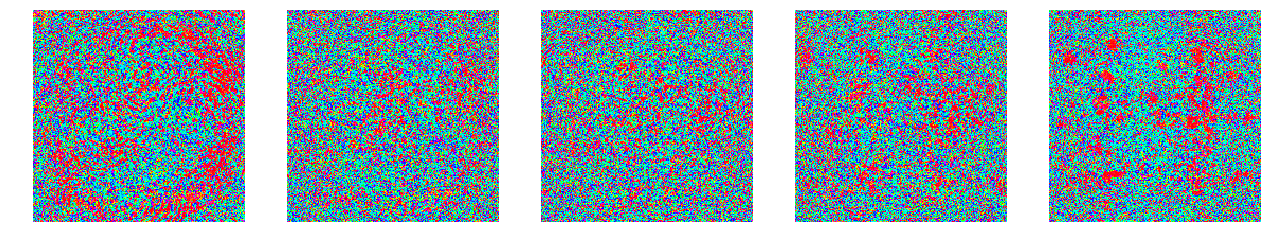

In [ ]:
# Visualization for phase modulation
model.phase_view(cmap="hsv")

0
7 torch.Size([200, 200])
0
7 torch.Size([200, 200])


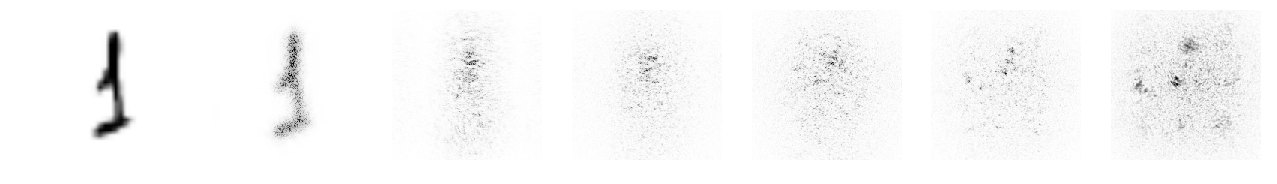

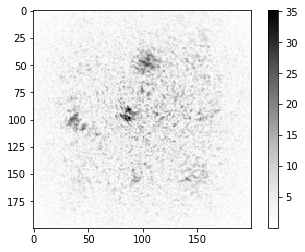

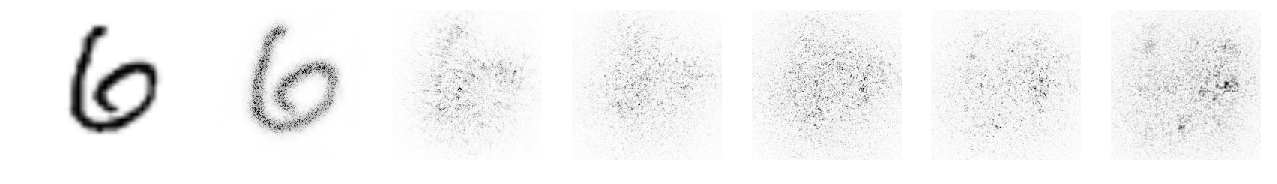

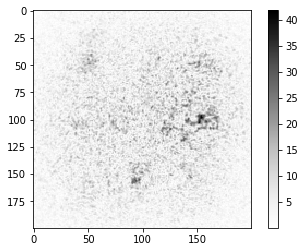

In [ ]:
# Visualization for propagation
transform = transforms.Compose([transforms.Resize((sys_size),interpolation=2),transforms.ToTensor()])
val_dataset = torchvision.datasets.MNIST("./data/", train=False, transform=transform, download=True)

with torch.no_grad():
  model.eval()
  val_img, val_label =val_dataset[900]
  model.prop_view(val_img.to(device))
  val_img, val_label =val_dataset[11]
  model.prop_view(val_img.to(device))